In [45]:
import matplotlib.pyplot as plt
import numpy as np

import seibot
import kontrol

_list = ["low_low", "low_mid", "low_high", "mid_low", "mid_mid", "mid_high", "high_low", "high_mid", "high_high"]
h1_path = "../filter_design/complementary_filters/old/h1_"
h2_path = "../filter_design/complementary_filters/old/h2_"
hsc_path = "../filter_design/sensor_correction_filters/old/h_sc_"

lp_list = []
hp_list = []
sc_list = []

for level in _list:
    lp = kontrol.load_transfer_function(h1_path+level+".pkl")
    hp = kontrol.load_transfer_function(h2_path+level+".pkl")
    hsc = kontrol.load_transfer_function(hsc_path+level+".pkl")
    lp_list.append(lp)
    hp_list.append(hp)
    sc_list.append(hsc)


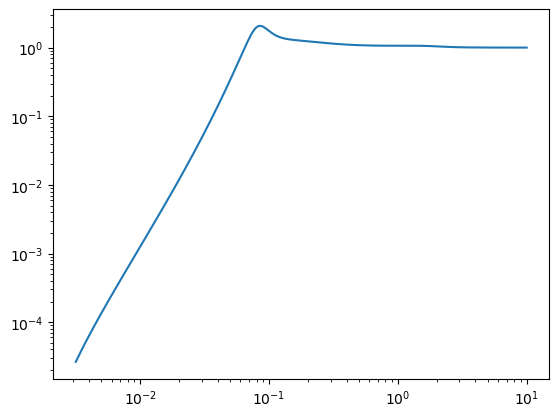

In [46]:
import matplotlib.pyplot as plt
import numpy as np


f = np.logspace(-2.5, 1, 1024)

plt.loglog(f, abs(hp_list[1](1j*2*np.pi*f)))

In [47]:
seismic_path = "../model_parameters/seismic_mean.txt"
seismic_parameters = np.loadtxt(seismic_path)
model = seibot.model.Model()
seismic_model = model.transfer_function(f, *seismic_parameters)
seismic = abs(seismic_model(1j*2*np.pi*f))

In [48]:
path = "../model_parameters/sts_mean.txt"
parameters = np.loadtxt(path)
model = seibot.model.Model()
seismometer_model = model.transfer_function(f, *parameters)
seismometer = abs(seismometer_model(1j*2*np.pi*f))

In [49]:
path = "../model_parameters/cps.txt"
parameters = np.loadtxt(path)
model = seibot.model.Model()
relative = model.noise2(f, *parameters)


In [50]:
path = "../model_parameters/inert_mean.txt"
parameters = np.loadtxt(path)
model = seibot.model.Model()
inert = model.transfer_function(f, *parameters)
inertial = abs(inert(1j*2*np.pi*f))

In [51]:
path = "../model_parameters/plant.txt"
parameters = np.loadtxt(path)
model = seibot.model.Model()
plant = model.second_order_plant(f, *parameters)


In [52]:
path = "../model_parameters/transmissivity.txt"
parameters = np.loadtxt(path)
model = seibot.model.Model()
transmissivity = model.second_order_plant(f, *parameters)

In [53]:
# filter_file = self.config["Controller"].get("filter_file")
# module = self.config["Controller"].get("module")
# fm = self.config["Controller"].get("fm")

# fm_list = [int(fm.strip()) for fm in fm.split(",")]

filter_file = "../foton_files/L1ISIHAM8.txt"
module = "HAM8_ISO_Y"
fm_list = [4, 8]

foton = seibot.foton.Foton(filter_file)
controller = -foton.get_filter_tf(module, fm_list)


In [54]:
relative_sensor = seibot.isolation_system.Sensor(f, relative)
inertial_sensor = seibot.isolation_system.Sensor(f, inertial)
seismometer_sensor = seibot.isolation_system.Sensor(f, seismometer)
plant_process = seibot.isolation_system.Process(plant)
plant_process.mag = abs(plant(1j*2*np.pi*f))
transmissivity_process = seibot.isolation_system.Process(transmissivity)
transmissivity_process.mag = abs(transmissivity(1j*2*np.pi*f))
controller = seibot.isolation_system.Process(controller)
controller.mag = abs(controller(1j*2*np.pi*f))

oltf = plant * controller
sensitivity = 1 / (1+oltf)
complement = oltf / (1+oltf)

sensitivity = seibot.isolation_system.Process(sensitivity)
sensitivity.mag = abs(sensitivity(1j*2*np.pi*f))
complement = seibot.isolation_system.Process(complement)
complement.mag = abs(complement(1j*2*np.pi*f))

In [55]:
ham8 = seibot.isolation_system.IsolationSystem(
    relative_sensor, inertial_sensor, seismometer_sensor,
    plant_process, transmissivity_process, controller,
    sensitivity, complement)

In [56]:
displacements = []

for sc in sc_list:
    for lp, hp in zip(lp_list, hp_list):
        lp = seibot.filter.Filter(lp)
        lp.mag = abs(lp(1j*2*np.pi*f))
        
        hp = seibot.filter.Filter(hp)
        hp.mag = abs(hp(1j*2*np.pi*f))
        
        sc = seibot.filter.Filter(sc)
        sc.mag = abs(sc(1j*2*np.pi*f))
        sc.mag_comp = abs((1-sc)(1j*2*np.pi*f))
        
        ham8.low_pass_filter = lp
        ham8.high_pass_filter = hp
        ham8.sensor_correction_filter = sc
    
        disp = ham8.get_displacement(seismic)
        displacements.append(disp)

In [81]:
ratio = 0.0
golden_mean = (np.sqrt(5)-1.0)/2.0

fig_width_pt = 560# Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27 # Convert pt to inch
fig_ratio = ratio if ratio != 0.0 else golden_mean # Aesthetic ratio, unless specified through ratio
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean # height in inches
fig_size =  [fig_width,fig_height]

font_size = 14
# COLOR SCHEME

# LOAD PLOTTING OPTIONS
params = {
		'text.usetex': True,
		'font.family': 'serif',
		'font.size': font_size,
		'axes.labelsize': font_size,
		'legend.fontsize': font_size,
		'xtick.labelsize': font_size,
		'ytick.labelsize': font_size,
		# 'axes.grid' : True,
		'lines.markersize' : 14,
		'lines.linewidth' : 2,
		'axes.formatter.useoffset': False,
		'figure.figsize': fig_size
		}

plt.rcParams.update(params)

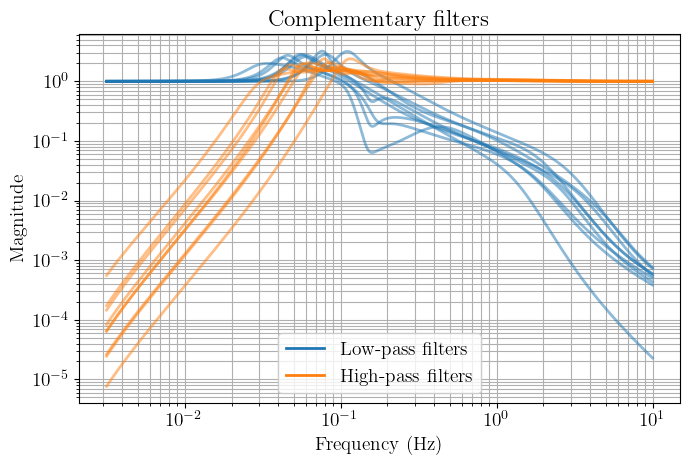

In [96]:

plt.title("Complementary filters")
# plt.loglog(f, seismic, color="C0", label="Seismic noise")

for lp in lp_list:
    plt.loglog(f, abs(lp(1j*2*np.pi*f)), color="C0", alpha=0.5)

for hp in hp_list:
    plt.loglog(f, abs(hp(1j*2*np.pi*f)), color="C1", alpha=0.5)

plt.loglog([], [], color="C0", label="Low-pass filters")
plt.loglog([], [], color="C1", label="High-pass filters")
# plt.loglog(f, displacements[min_i], color="C1", label="Best", lw=2)

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

plt.savefig("complementary_filters.png", bbox_inches="tight", dpi=256)

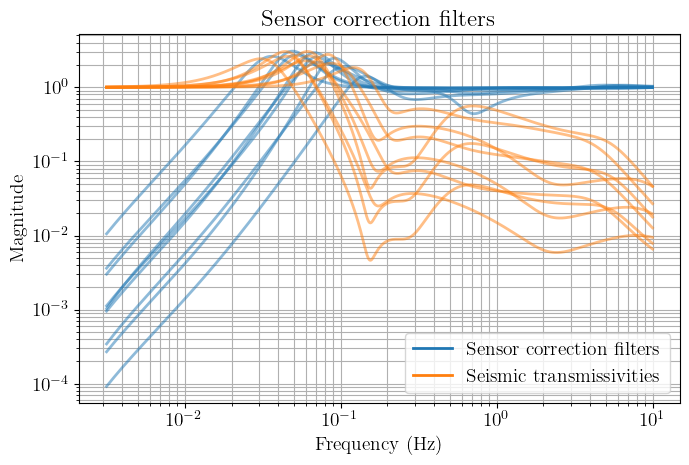

In [122]:

plt.title("Sensor correction filters")
# plt.loglog(f, seismic, color="C0", label="Seismic noise")

for sc in sc_list:
    plt.loglog(f, abs(sc(1j*2*np.pi*f)), color="C0", alpha=0.5)

for sc in sc_list:
    plt.loglog(f, abs((1-sc)(1j*2*np.pi*f)), color="C1", alpha=0.5)

plt.loglog([], [], color="C0", label="Sensor correction filters")
plt.loglog([], [], color="C1", label="Seismic transmissivities")
# plt.loglog([], [], color="C1", label="High-pass filters")
# plt.loglog(f, displacements[min_i], color="C1", label="Best", lw=2)

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

plt.savefig("sensor_correction_filters.png", bbox_inches="tight", dpi=256)

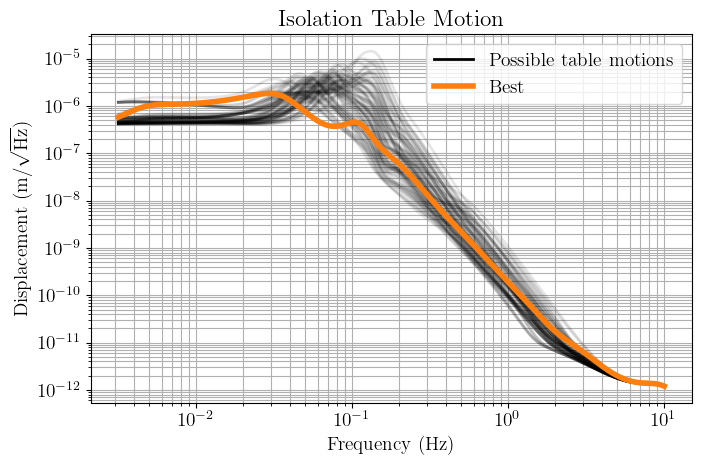

In [123]:

plt.title("Isolation Table Motion")
# plt.loglog(f, seismic, color="C0", label="Seismic noise")

for disp in displacements:
    plt.loglog(f, disp, color="k", alpha=0.1)

plt.loglog([], [], color="k", label="Possible table motions")
plt.loglog(f, displacements[min_i], color="C1", label="Best", lw=4)

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Displacement $(\mathrm{m}/\sqrt{\mathrm{Hz}})$")
plt.xlabel("Frequency (Hz)")

plt.savefig("best_displacement.png", bbox_inches="tight", dpi=256)

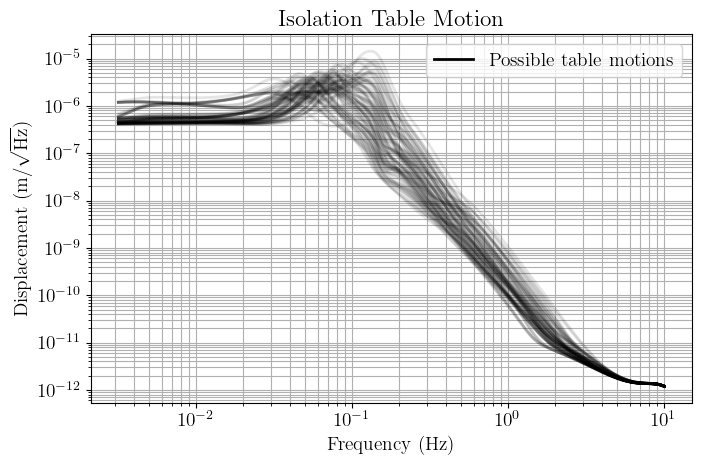

In [85]:

plt.title("Isolation Table Motion")
# plt.loglog(f, seismic, color="C0", label="Seismic noise")

for disp in displacements:
    plt.loglog(f, disp, color="k", alpha=0.1)

plt.loglog([], [], color="k", label="Possible table motions")
# plt.loglog(f, displacements[min_i], color="C1", label="Best", lw=2)

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Displacement $(\mathrm{m}/\sqrt{\mathrm{Hz}})$")
plt.xlabel("Frequency (Hz)")

plt.savefig("possible_displacement.png", bbox_inches="tight", dpi=256)

In [69]:
# evaluate = seibot.evaluate.Evaluate()
rmss = []
for disp in displacements:
    rms = kontrol.spectral.asd2rms(f=f, asd=disp*2*np.pi*f, return_series=False)
    rmss.append(rms)

min_i = np.argmin(rmss)

In [76]:
rmss[min_i]

9.298568991188162e-08

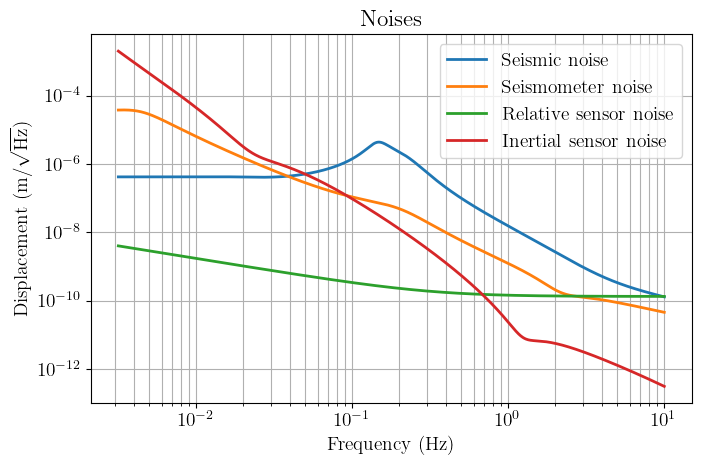

In [108]:
plt.title("Noises")
plt.loglog(f, seismic, label="Seismic noise")
plt.loglog(f, seismometer, label="Seismometer noise")
plt.loglog(f, relative, label="Relative sensor noise")
plt.loglog(f, inertial, label="Inertial sensor noise")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Displacement $(\mathrm{m}/\sqrt{\mathrm{Hz}})$")
plt.xlabel("Frequency (Hz)")
# plt.loglog(f, disp)
plt.savefig("noises.png", bbox_inches="tight", dpi=256)

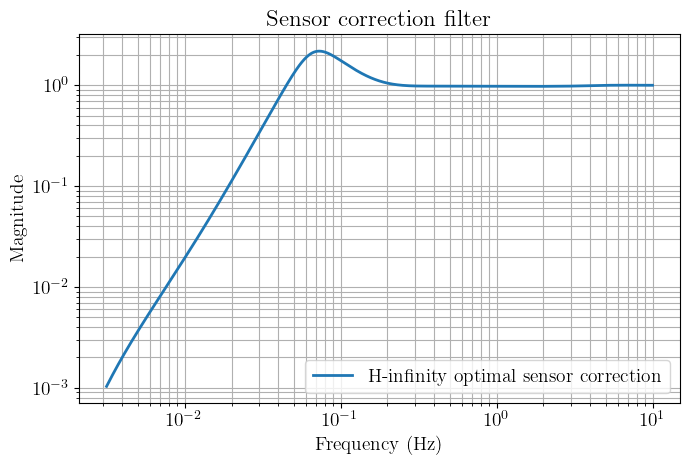

In [113]:
plt.title("Sensor correction filter")
plt.loglog(f, abs(sc_list[0](1j*2*np.pi*f)), label="H-infinity optimal sensor correction")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")
plt.savefig("one_sensor_correction_filter.png", bbox_inches="tight", dpi=256)

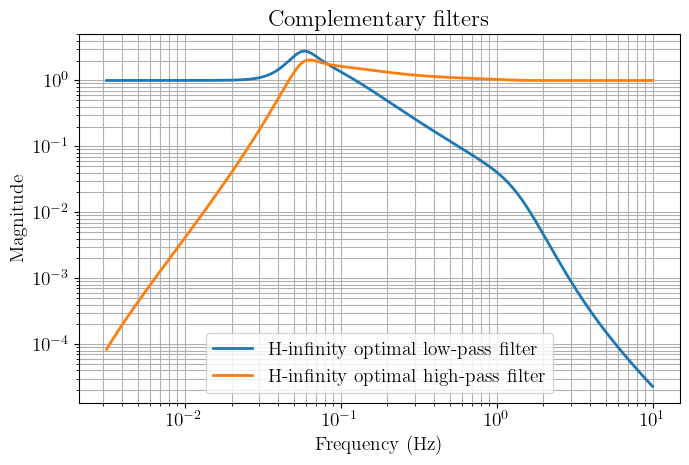

In [121]:
plt.title("Complementary filters")
plt.loglog(f, abs(lp_list[0](1j*2*np.pi*f)), label="H-infinity optimal low-pass filter")
plt.loglog(f, abs(hp_list[0](1j*2*np.pi*f)), label="H-infinity optimal high-pass filter")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")
plt.savefig("one_complementary_filter.png", bbox_inches="tight", dpi=256)